# 차원 변환과 SVM

###  <div align=center> Moon Il-chul(icmoon@kaist.ac.kr); Kim Hye-mi(khm0308@kaist.ac.kr) </div>

본 코드는 데이터의 차원을 높인 후, Support Vector Machine을 활용하여 데이터 특성에 알맞는 Decision Boundary를 찾아내는 구현 예시입니다.
본 코드를 통하여 본 코드는 2차원 평면에 label 되어 있는 데이터를 차원 확장을 통해 비선형 Decision Boundary로 분류할 수 있습니다.

### 비선형 결정경계와 차원확장
앞의 Hard Margin과 Soft Margin 코드에서는 선형 Decisino Boundary로 데이터셋을 Classification하였습니다. 이 두 모델은 데이터셋을 선형으로 분류하는 것이 불가능할 때, 주어진 데이터셋을 제대로 Classification하지 못한다는 한계가 있습니다.  

이러한 한계는 SVM에 쓰일 데이터셋의 차원을 높여 비선형적 Decision Boundary를 이용함으로써 해결할 수 있습니다. 해당코드에서는 2차원의 데이터 $x_1, x_2$를 다음과 같이 확장하여 주어진 데이터셋의 Decision Boundary를 찾을 예정입니다.

$$ \phi(<x_1, x_2>) = <x_1, x_2, x_1^2, x_2^2, x_1 x_2, x_1^3, x_2^3, x_1^2 x_2, x_1 x_2^2> $$


더 나아가 SVM Kernel Trick 코드에서 무한대차수까지 차수를 확장하고, 조금 더 데이터에 적합하게 차원을 확장하는 방법을 다룰 예정입니다.

In [46]:
'''
@ copyright: AAI lab (http://aailab.kaist.ac.kr/xe2/page_GBex27)
@ author: Moon Il-chul: icmoon@kaist.ac.kr
@ annotated by Kim Hye-mi: khm0308@kaist.ac.kr
'''
import numpy as np
from cvxopt import matrix, solvers
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D

In [47]:
%matplotlib inline

In [48]:
# Positive / Negative 데이터 생성
pos = np.array([[3, 7], [4, 6], [5, 6], [7, 7], [8, 5], [5, 5.2], [7, 5], [6, 3.75], [6, 4], [6, 5], [7, 5], [6, 4.5], [7, 4.5]])
neg = np.array([[4, 5], [5, 5], [6, 3], [7, 4], [9, 4], [5, 4], [5, 4.5], [5, 3.5], [7, 3.5]])

# X: 전체 데이터를 저장
X = np.ones((pos.shape[0] + neg.shape[0], 2)) 
X[0:pos.shape[0], 0:2] = pos # 앞부분은 positive 데이터를 저장
X[pos.shape[0]:pos.shape[0]+neg.shape[0], 0:2] = neg # 뒷부분은 negative 데이터를 저장

# Y: 전체 데이터에 대한 label을 저장
Y = np.ones(pos.shape[0] + neg.shape[0])
Y[0:pos.shape[0]] = 1 # 앞부분은 positive 데이터에 대한 label로 +1을 저장
Y[pos.shape[0]:pos.shape[0]+neg.shape[0]] = -1 # 뒷부분은 negative 데이터에 대한 label로 -1을 저장

C = 10 # 절층매개변수 고정

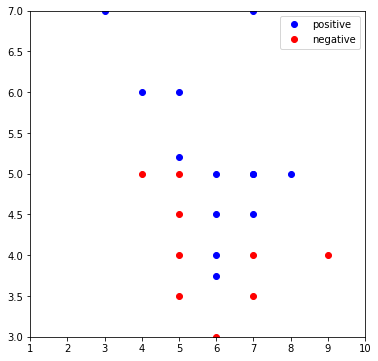

In [49]:
# 데이터셋 plotting
plt.figure(figsize = (6, 6))
plt.axis((1, 10, 3, 7))
plt.figure(1, figsize = (7, 7))
plt.plot(X[0:pos.shape[0], 0], X[0:pos.shape[0], 1], 'bo', label = 'positive')
plt.plot(X[pos.shape[0]:pos.shape[0] + neg.shape[0], 0], X[pos.shape[0]:pos.shape[0] + neg.shape[0], 1], 'ro', label = 'negative')
plt.legend()
plt.show()

In [50]:
# A: optimization problem에서 제약식 좌측항의 w의 계수(부등호 방향을 맞춰주기 위해 (-1)을 곱함)
A = np.zeros((X.shape[0] + X.shape[0], X.shape[1] + X.shape[0] + 1))

for i in range(X.shape[0]): # for문 에서 제약식에서 (wx+b)y+e>=1 항의 좌측항을 업데이트함
    for j in range(X.shape[1]):
        A[i, j] = X[i, j] * Y[i] * (-1) # -xij＊yi
    A[i, X.shape[1]] = Y[i] * (-1) # -bi
    A[i, X.shape[1] + i + 1] = -1 # -ei (error)

# 제약식에서 e>=0 항의 좌측항을 나타냄
for i in range(X.shape[0]):
    A[i + X.shape[0], X.shape[1] + i + 1] = -1
    
# b: optimization problem에서 제약식 우측항의 값
b = np.zeros(X.shape[0] + X.shape[0])
# 제약식에서 (wx+b)y+e>=1 항의 우측항을 나타냄; e>=0 항의 우측항은 0으로 위에서 설정됨
b[0:X.shape[0]] = -1

# H: w의 quadratic term의 계수
H = np.zeros((X.shape[1] + 1 + X.shape[0], X.shape[1] + 1 + X.shape[0]))
for i in range(X.shape[1]):
    H[i, i]  =  1

# w의 일차항의 계수로 에러항에 곱해줄 절충 매개변수 C (slack variable에 대한 계수)
f = np.zeros(X.shape[1] + 1 + X.shape[0])
for i in range(X.shape[1] + 1, X.shape[1] + 1 + X.shape[0]):
    f[i] = C
    
H = matrix(H)
f = matrix(f)
A = matrix(A)
b = matrix(b)

# optimization problem을 풀어줌: min 1/2xTHx+fTx s.t. Ax =< b
sol = solvers.qp(H, f, A, b)
w = sol['x']
#w = np.asarray(sol['x'])
a = -np.dot(A,w)

     pcost       dcost       gap    pres   dres
 0: -1.3899e+03  9.7509e+02  3e+03  2e+01  4e+00
 1:  4.4299e+02  4.8574e+01  4e+02  7e-15  3e-15
 2:  1.4738e+02  8.0062e+01  7e+01  6e-15  5e-14
 3:  1.2318e+02  1.0196e+02  2e+01  2e-15  1e-13
 4:  1.1273e+02  1.0782e+02  5e+00  2e-15  1e-13
 5:  1.1052e+02  1.0995e+02  6e-01  1e-15  1e-14
 6:  1.1016e+02  1.1016e+02  7e-03  1e-15  1e-13
 7:  1.1016e+02  1.1016e+02  7e-05  1e-15  3e-13
Optimal solution found.


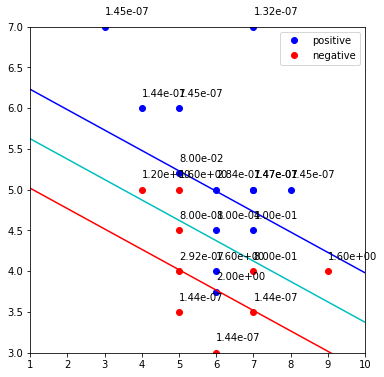

In [51]:
# 기존데이터 plotting
plt.figure(figsize = (6, 6))
plt.axis((1, 10, 3, 7))
plt.figure(1, figsize = (7, 7))
plt.plot(X[0:pos.shape[0], 0], X[0:pos.shape[0], 1], 'bo', label = 'positive')
plt.plot(X[pos.shape[0]:pos.shape[0] + neg.shape[0], 0], X[pos.shape[0]:pos.shape[0] + neg.shape[0], 1], 'ro', label = 'negative')
plt.legend()

for i in range(X.shape[0]):
    plt.text(X[i, 0], X[i, 1], '%.2e\n'%(w[i + int(X.shape[1]) + 1]))
    
lineX = [1, 10]

# plotting decision-boundary
lineY0 = [(w[2] + w[0]*lineX[0])/-w[1], (w[2] + w[0]*lineX[1])/-w[1]]
plt.plot(lineX, lineY0, 'c')

# margin distance 계산
margin = 1 / np.linalg.norm(w[0:2])

# Positive data 가운데 Negative data들과 가장 가까운 두개의 점을 지나는 직선
lineY1 = [(w[2] + w[0]*lineX[0])/-w[1] + margin, (w[2] + w[0]*lineX[1])/-w[1] + margin]
plt.plot(lineX, lineY1, 'b-')

# Negative data 가운데 Negative data들과 가장 가까운 점을 지나는 직선
lineY2 = [(w[2] + w[0]*lineX[0])/-w[1] - margin, (w[2] + w[0]*lineX[1])/-w[1] - margin]
plt.plot(lineX, lineY2, 'r-')

a = -1 * np.dot(A, w)
    
plt.show()

### 결과해석부 (비선형 데이터와 Soft Margin)
해당 데이터셋은 선형 Decisino Boundary로 데이터셋을 Classification할 수 없는 경우입니다. Soft Margin으로 해당 데이터 셋의 Classification을 수행했을 때, Optimization problem의 결과가 주어진 데이터셋을 정확히 분류하지 못하는 것을 확인할 수 있습니다. 따라서 차원을 변형시켜 비선형 Decision Boundary로 주어진 데이터를 Classification할 예정입니다.

In [52]:
# X의 차원확장: <x1, x2> => <x1, x2, x1^2, x2^2,  x1 + x2, x1^3, x1^2 * x2, x1 * x2^2, x2^3>
X = np.ones((pos.shape[0] + neg.shape[0], 9)) 
X[0:pos.shape[0], 0:2] = pos # x1, x2 앞부분
X[pos.shape[0]:pos.shape[0]+neg.shape[0], 0:2] = neg # x1, x2 뒷부분

X[:, 2] = X[:, 0] * X[:, 0] # x1^2
X[:, 3] = X[:, 1] * X[:, 1] # x2^2
X[:, 4] = X[:, 0] * X[:, 1] # x1 + x2

X[:, 5] = X[:, 2] * X[:, 0] # x1^3
X[:, 6] = X[:, 3] * X[:, 1] # x1^2 * x2
X[:, 7] = X[:, 4] * X[:, 0] # x1 * x2^2 
X[:, 8] = X[:, 4] * X[:, 1] # x2^3

In [53]:
# A: optimization problem에서 제약식 좌측항의 w의 계수(부등호 방향을 맞춰주기 위해 (-1)을 곱함)
A = np.zeros((X.shape[0] + X.shape[0], X.shape[1] + X.shape[0] + 1))

for i in range(X.shape[0]): # for문 에서 제약식에서 (wx+b)y+e>=1 항의 좌측항을 업데이트함
    for j in range(X.shape[1]):
        A[i, j] = X[i, j] * Y[i] * (-1) # -xij＊yi
    A[i, X.shape[1]] = Y[i] * (-1) # -bi
    A[i, X.shape[1] + i + 1] = -1 # -ei (error)

# 제약식에서 e>=0 항의 좌측항을 나타냄
for i in range(X.shape[0]):
    A[i + X.shape[0], X.shape[1] + i + 1] = -1
    
# b: optimization problem에서 제약식 우측항의 값
b = np.zeros(X.shape[0] + X.shape[0])
# 제약식에서 (wx+b)y+e>=1 항의 우측항을 나타냄; e>=0 항의 우측항은 0으로 위에서 설정됨
b[0:X.shape[0]] = -1

# H: w의 quadratic term의 계수
H = np.zeros((X.shape[1] + 1 + X.shape[0], X.shape[1] + 1 + X.shape[0]))
for i in range(X.shape[1]):
    H[i, i]  =  1

# w의 일차항의 계수로 에러항에 곱해줄 절충 매개변수 C (slack variable에 대한 계수)
f = np.zeros(X.shape[1] + 1 + X.shape[0])
for i in range(X.shape[1] + 1, X.shape[1] + 1 + X.shape[0]):
    f[i] = C
    
H = matrix(H)
f = matrix(f)
A = matrix(A)
b = matrix(b)

# optimization problem을 풀어줌: min 1/2xTHx+fTx s.t. Ax =< b
sol = solvers.qp(H, f, A, b)
w = sol['x']
#w = np.asarray(sol['x'])
a = -np.dot(A,w)

     pcost       dcost       gap    pres   dres
 0: -1.7113e+03  5.0107e+02  2e+03  2e+01  1e+02
 1: -5.1425e+02 -2.6851e+01  6e+02  6e+00  4e+01
 2: -1.3970e+02 -6.1672e+01  3e+02  2e+00  1e+01
 3: -6.1618e-01 -4.8660e+00  5e+01  3e-01  2e+00
 4:  1.3650e+01  1.1177e+01  1e+01  5e-02  3e-01
 5:  1.5474e+01  1.3468e+01  3e+00  4e-03  2e-02
 6:  1.4767e+01  1.4443e+01  3e-01  6e-14  2e-11
 7:  1.4561e+01  1.4557e+01  4e-03  7e-14  5e-11
 8:  1.4559e+01  1.4559e+01  4e-05  4e-14  4e-11
 9:  1.4559e+01  1.4559e+01  4e-07  4e-14  3e-11
Optimal solution found.


In [54]:
x1 = np.linspace(1, 10) # 시작점(1)과 끝점(10) 사이를 균일한 간격으로 나눈 점들을 x1에 저장함
x2 = np.linspace(3, 7) # 시작점(3)과 끝점(7) 사이를 균일한 간격으로 나눈 점들을 x2에 저장함
xx1, xx2 = np.meshgrid(x1, x2) # (x1, x2)에 대한 그리드 포인트를 생성함. xx1은 그리드 포인트의 X값만, xx2는 Y값만 표시하는 행렬임

f = np.zeros((len(x1), len(x2))) # 각 지점에 대한 함수값

# <x1, x2> 차원을 <x1, x2, x1^2, x2^2,  x1 + x2, x1^3, x1^2 * x2, x1 * x2^2, x2^3>로 확장함
for i in range(len(x1)):
    for j in range(len(x2)):
        temp = np.zeros((X.shape[1], 1))
        temp[0] = x1[i]
        temp[1] = x2[j]
        temp[2] = x1[i]*x1[i]
        temp[3] = x2[j]*x2[j]
        temp[4] = x1[i]*x2[j]
        temp[5] = x1[i]*x1[i]*x1[i]
        temp[6] = x2[j]*x2[j]*x2[j]
        temp[7] = x1[i]*x1[i]*x2[j]
        temp[8] = x1[i]*x2[j]*x2[j]
        
        # 내적을 통해 위에서 구한 해를 확장된 차원으로 변환
        f[j, i] = np.dot(w[0:X.shape[1]].T, temp) + w[X.shape[1]]

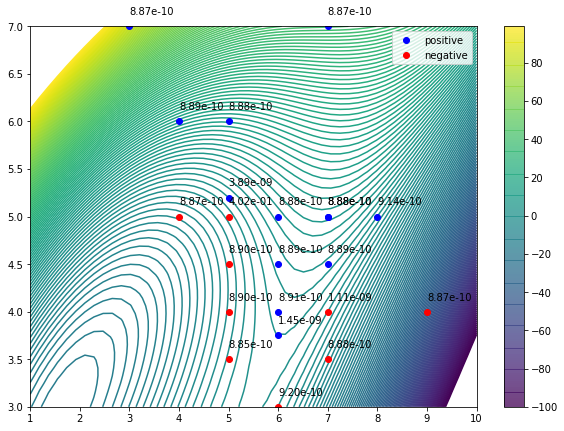

In [55]:
lev = np.arange(-100, 100, 1) # -100에서 100까지 1씩 증가한 값을 저장

fig = plt.figure(1, figsize = (10, 7))
plt.axis((1, 10, 3, 7))

# 원래 데이터를 Postivie는 파란색 점, Negative는 빨강색 점으로 plotting함
plt.plot(X[0:pos.shape[0], 0], X[0:pos.shape[0], 1], 'bo', label = 'positive')
plt.plot(X[pos.shape[0]:pos.shape[0] + neg.shape[0], 0], X[pos.shape[0]:pos.shape[0] + neg.shape[0], 1], 'ro', label = 'negative')

plt.legend()

for i in range(X.shape[0]):
    plt.text(X[i, 0], X[i, 1], '%.2e\n'%(w[i + int(X.shape[1]) + 1]))

c = plt.contour(x1, x2, f, levels = lev, linestyles = 'solid') # 2차원 데이터에 대한 f의 값을 3차원에서 나타냄

cbar = plt.colorbar(c) # f 값에 대한 등고선을 나타냄
plt.show()

### 결과해석부
각 점에 적혀있는 값은 $x1$과 $x2$에 대한 $ \phi(<x_1, x_2>) = <x_1, x_2, x_1^2, x_2^2, x_1 x_2, x_1^3, x_2^3, x_1^2 x_2, x_1 x_2^2> $값을 의미합니다. 동일한 값을 가진 점들은 동일한 등고선상에 위치함을 확인할 수 있습니다. 해당 그래프의 등고선의 곡률의 변화하는 지점에서 Positive data와 Negative data를 잘 분류하고 있음을 확인할 수 있습니다.

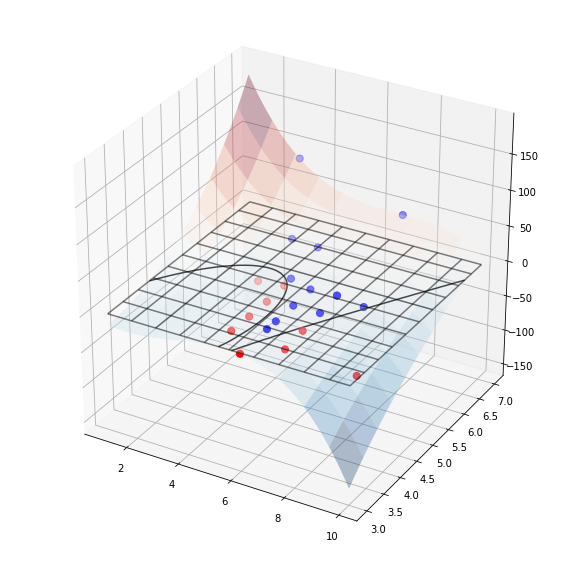

In [56]:
%matplotlib qt
fig = plt.figure(figsize = (10, 10))

ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot_surface(xx1, xx2, f, rstride=5, cstride=5, cmap='RdBu_r', alpha = 0.3)
ax.scatter(X[0:pos.shape[0], 0], X[0:pos.shape[0], 1], np.dot(w[0:X.shape[1]].T, X[0:pos.shape[0], :].T) + w[X.shape[1]], c = 'b', s = 50)
ax.scatter(X[pos.shape[0]:pos.shape[0] + neg.shape[0], 0], X[pos.shape[0]:pos.shape[0] + neg.shape[0], 1], 
           np.dot(w[0:X.shape[1]].T, X[pos.shape[0]:pos.shape[0] + neg.shape[0]].T) + w[X.shape[1]], c = 'r', s = 50)
ax.plot_wireframe(xx1, xx2, np.zeros((len(x1), len(x2))), rstride=5, cstride=5, colors = 'k', alpha = 0.5)
plt.contour(x1, x2, f, levels = [0], colors = 'k', linestyles = 'solid')
plt.show()

### 결과해석부
위 그래프는 앞선 등고선 그래프를 3차원으로 나타낸 것입니다. 차원확장의 결과로 2차원에 위치한 Positive data(파랑색 점)와 Negative data(빨강색 점)이 추가된 z축에서 값을 가지며, 한 z평면을 기준으로 두 데이터 셋이 나뉘는 것을 확인할 수 있습니다. 해당 평면에서의 등고선 값이 곧 비선형 Decision Boundary입니다. 이 Decision Boundary는 두 데이터 셋을 원래의 2차원 평면에서 잘 분류하고 있음을 확인할 수 있습니다.